In [1]:
import sys
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # montar el drive, que es donde tenemos el dataset
    from google.colab import drive
    drive.mount("/content/drive")
    data_dir = "/content/drive/MyDrive/ASTURCON'23/Adversarial_attacks"
    sys.path.append(data_dir)
else:
    import os
    data_dir = "."

In [2]:
import  tensorflow  as  tf
import  keras

import  matplotlib.pyplot  as  plt
import  numpy  as  np

from  keras  import  backend  as  k
from  keras.applications.inception_v3  import  InceptionV3, decode_predictions


tf.compat.v1.disable_eager_execution ()

2023-11-08 19:38:36.017833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
iv3 = InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.


2023-11-08 19:38:49.960414: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-11-08 19:38:50.207356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-11-08 19:38:50.912829: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_68/moving_variance/Assign' id:4069 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_68/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_68/moving_variance, batch_normalization_68/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [62]:
# iv3.summary()

In [8]:
from tensorflow.keras.preprocessing import image

goldfish = '/goldfish.jpg'
goldfishHackImage = '/goldfishHackImage.png'

beer = '/beer.jpg'
beerHackImage = '/beerHackImage.png'

kitty = '/kitty.jpg'
kittyHackImage = '/kittyHackImage.png'


img = image.img_to_array(image.load_img(data_dir + beerHackImage, target_size=(299, 299)))
print(img.shape)

(299, 299, 3)




```
# Tiene formato de código
```

- Si se imprime img los resultados van a ser de 0 a 255 los colores pero incepcion funciona de -1 a 1 para lo cual se va a reescalar la imagen

In [9]:
# Conversión de 0-255 a -1-1
img /= 255
img -= 0.5
img *= 2


In [10]:
# El modelo pide que entre un tensor con una dimension mas esa dimension extra es el tamaño del batch (+1 imágen)
img = img.reshape([1, img.shape[0], img.shape[1], img.shape[2]])
print (img.shape)


(1, 299, 299, 3)


In [11]:
# Predicción
y=iv3.predict(img)
decode_predictions(y)

[[('n07749582', 'lemon', 0.9980629),
  ('n07747607', 'orange', 0.0010754343),
  ('n07718472', 'cucumber', 6.191176e-05),
  ('n03530642', 'honeycomb', 5.777204e-05),
  ('n07615774', 'ice_lolly', 5.2940984e-05)]]



```
# Tiene formato de código
```

## Ataque adversario

In [67]:
# Vamos a construir un nuevo grapho que permita clasificar las imágenes.
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# lemon -> 951
# speedboat -> 814
# pelican -> 144
# more info on-> https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json

target_class = 144


loss = out_layer[0, target_class]

grad = k.gradients(loss, inp_layer)[0]

# Que calcule el grafo de gradientes entre el tensor y la funcion de coste #tensor que dice como variar los pixeles
optimize_gradient = k.function([inp_layer, k.learning_phase()], [grad, loss])



In [68]:

pert=0.01

max_pert=img+pert
min_pert=img-pert

# adv = np.copy(img)


cost = 0.01
adv = np.copy(img)

while cost<0.95:
    gr, cost = optimize_gradient([adv, 0])
    adv += gr

    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1, 1)
    print('Coste de limón: ', cost)

Coste de limón:  2.126033e-05
Coste de limón:  2.128815e-05
Coste de limón:  2.1322507e-05
Coste de limón:  2.1379572e-05
Coste de limón:  2.143714e-05
Coste de limón:  2.1497712e-05
Coste de limón:  2.1559325e-05
Coste de limón:  2.162035e-05
Coste de limón:  2.1680786e-05
Coste de limón:  2.1741622e-05
Coste de limón:  2.1802807e-05
Coste de limón:  2.1864878e-05
Coste de limón:  2.1926953e-05
Coste de limón:  2.1989184e-05
Coste de limón:  2.2053197e-05
Coste de limón:  2.2117873e-05
Coste de limón:  2.2182296e-05
Coste de limón:  2.2247952e-05
Coste de limón:  2.23147e-05
Coste de limón:  2.238204e-05
Coste de limón:  2.2450093e-05
Coste de limón:  2.2518021e-05
Coste de limón:  2.2587374e-05
Coste de limón:  2.2657216e-05
Coste de limón:  2.2727123e-05
Coste de limón:  2.2796552e-05
Coste de limón:  2.286615e-05
Coste de limón:  2.2936061e-05
Coste de limón:  2.3006607e-05
Coste de limón:  2.3077922e-05
Coste de limón:  2.314962e-05
Coste de limón:  2.3221886e-05
Coste de limón:  

In [69]:
print(adv.shape)

(1, 299, 299, 3)


In [70]:
adv /= 2
adv += 0.5
adv *= 255

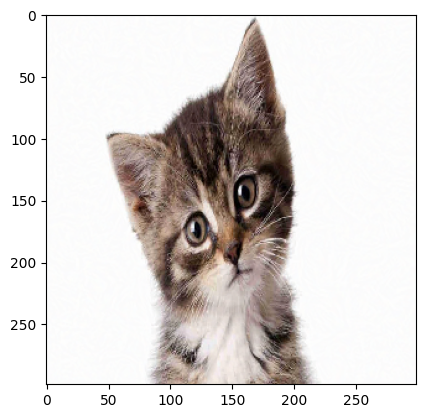

In [71]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [72]:
y=iv3.predict(adv)
decode_predictions(y)#pasa de y al resultado

[[('n01924916', 'flatworm', 1.0),
  ('n03950228', 'pitcher', 2.6596035e-13),
  ('n02841315', 'binoculars', 9.891405e-26),
  ('n03047690', 'clog', 5.111509e-26),
  ('n06359193', 'web_site', 3.0751277e-26)]]

In [73]:
from PIL import Image
im=Image.fromarray(adv[0].astype(np.uint8))
im.save(data_dir + kittyHackImage)